<font face='candara' size=12><center><b>Churn Prediction for Telecoms Business</b></center></font>

## Task 1:<br>Formulate and articulate the business problem(s) to be solved

## Skills:<br>Domain knowledge and/or access to business SMEs

## To Do:<ul><li>What question/problem does the business need you to answer?<li>Formulate the question so that it can be answered with data. See this <a href='https://sec.ch9.ms/ch9/31b8/a604ca06-0357-41bb-9a03-4791ae8d31b8/DataScienceForBeginnersAskQuestionYouCanAnswerWit_high.mp4'>video</a><li>What outcome(s) does the business hope for?<li>What are the business processes/operations?<li>How to measure performance of the project?<li>etc.

### Business Case Overview:
####  - The business spends a lot of money on targeted advertising, promotions and other activities aimed at customer retention.
####  - They would like to know which customers are likely to cancel their subscriptions
####  - They would also like to know what factors drive customer churn
####  - This will enable them to save money on customer retention activities targeting these specific customers
####  - They could also, possibly, be able to reach at-risk customers before they churn
####  - The business is particularly concerned about false negatives (i.e. classifying customers as NOT churning who will churn)
####  - The business is not as concerned about false positives (i.e. classifying customers as churning who will NOT churn)

In [1]:
%reset -f

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer

from skopt import BayesSearchCV

from xgboost import XGBClassifier

from collections import Counter, defaultdict

import psutil

from colorama import Style, Fore, Back

In [4]:
np.random.seed(0)

## Task 2:<br>Identify the dataset(s) needed to answer these questions

## Skills:<br>Data access and skills, data engineer, "gatekeeper" (e.g. SQL, pyodbc, Python, Excel, Rick)

## To Do:<ul><li>Is there data and enough of it? See this <a href='https://sec.ch9.ms/ch9/8c9a/aab9492b-4167-41f0-9b9f-4eab661e8c9a/DataScienceForBeginnersIsYourDataReadyForDataScie_high.mp4'>video</a><li>Is the data accessible?<li>Is the data relevant?<li>Is the data complete?<li>Is the data representative of the problem or is it imbalanced?<li>etc.

In [5]:
df = pd.read_csv('churn_data.csv')
df.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,...,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [6]:
df.shape

(3333, 21)

In [7]:
# function to display UNIQUE examples of data in each field

def getDesc(df, thisFt, numExamples=5):
    x = list(set([i for i in df[thisFt] if i==i]))
    if len(x)<numExamples:
        numExamples = len(x)
    x = list(np.random.choice(x, size=numExamples, replace=False))
    print('Examples in '+Style.BRIGHT+thisFt+':'+Style.RESET_ALL, x, '\n')
    return None

# ======================================================================================

# function to display the number of missing values in each field

def getNumNan(df, thisFeature):
    ms = df[df[thisFeature] != df[thisFeature]].shape[0]
    print('Missing values in '+Style.BRIGHT+thisFeature+Style.RESET_ALL+': {}'.format(ms))
    return None

In [8]:
labelSkew = Counter(df['Churn'])

for i in labelSkew.keys():
    thisCount = round(100*labelSkew[i]/df.shape[0],1)
    print('Class '+str(i)+':', thisCount, '%')

Class 0: 85.5 %
Class 1: 14.5 %


In [9]:
# df.describe()

In [10]:
# df.info()

In [11]:
for i in df.columns:
    getNumNan(df,i)
    getDesc(df,i)

Missing values in Account Length: 0
Examples in Account Length: [217, 39, 91, 193, 151] 

Missing values in VMail Message: 0
Examples in VMail Message: [30, 27, 28, 17, 36] 

Missing values in Day Mins: 0
Examples in Day Mins: [237.9, 188.8, 155.1, 146.0, 127.9] 

Missing values in Eve Mins: 0
Examples in Eve Mins: [160.4, 165.3, 189.3, 243.5, 152.9] 

Missing values in Night Mins: 0
Examples in Night Mins: [160.2, 304.2, 206.7, 85.8, 100.3] 

Missing values in Intl Mins: 0
Examples in Intl Mins: [15.9, 2.7, 4.1, 12.8, 12.2] 

Missing values in CustServ Calls: 0
Examples in CustServ Calls: [9, 2, 5, 0, 7] 

Missing values in Churn: 0
Examples in Churn: [1, 0] 

Missing values in Int'l Plan: 0
Examples in Int'l Plan: [1, 0] 

Missing values in VMail Plan: 0
Examples in VMail Plan: [0, 1] 

Missing values in Day Calls: 0
Examples in Day Calls: [123, 56, 152, 119, 126] 

Missing values in Day Charge: 0
Examples in Day Charge: [29.77, 46.56, 26.83, 36.31, 37.09] 

Missing values in Eve Cal

## Task 3:<br>Explore the data

## Skills:<br>Data manipulations skills

## To Do:<ul><li>Is the data structured or unstructured?<li>What fields exist in the (structured) data?<li>Are there outliers? (e.g. Intl Mins = 1200)<li>Can new features/fields be engineered? (e.g. get location given an area code)<li>Is there possible data leakage? (e.g. a field "Account_Closed" may indicate churn)<li>etc.

In [12]:
# convert area-codes from INT to STR for possible geocoding
df['Area Code'] = [str(i) for i in df['Area Code']]

In [13]:
# engineer new field to replace "Phone Number"
df['Phone'] = [i+'-'+j for i,j in zip(df['Area Code'],df['Phone'])]

In [14]:
# Counter([len(i) for i in df['Phone']])

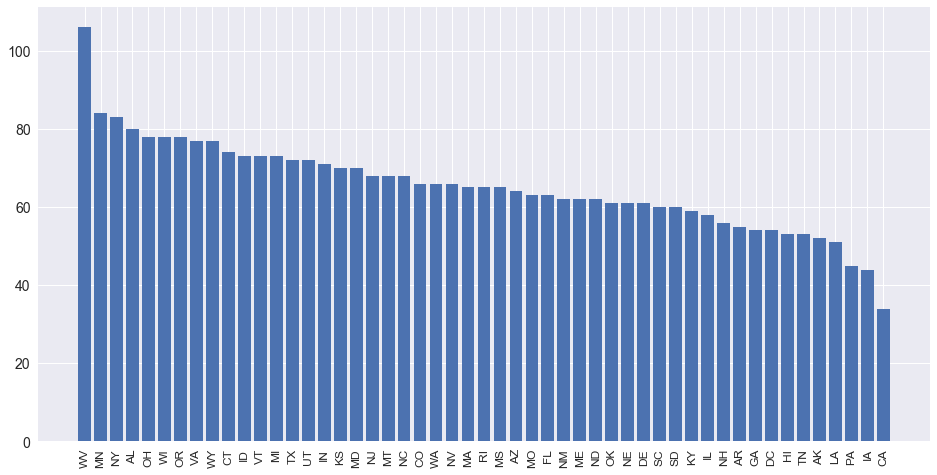

In [15]:
# check customer distribution by state of residence

stateDist = Counter(df['State']).most_common()
px = [i[0] for i in stateDist]
py = [i[1] for i in stateDist]

plt.figure(figsize=[16,8])
plt.bar(px, py)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()

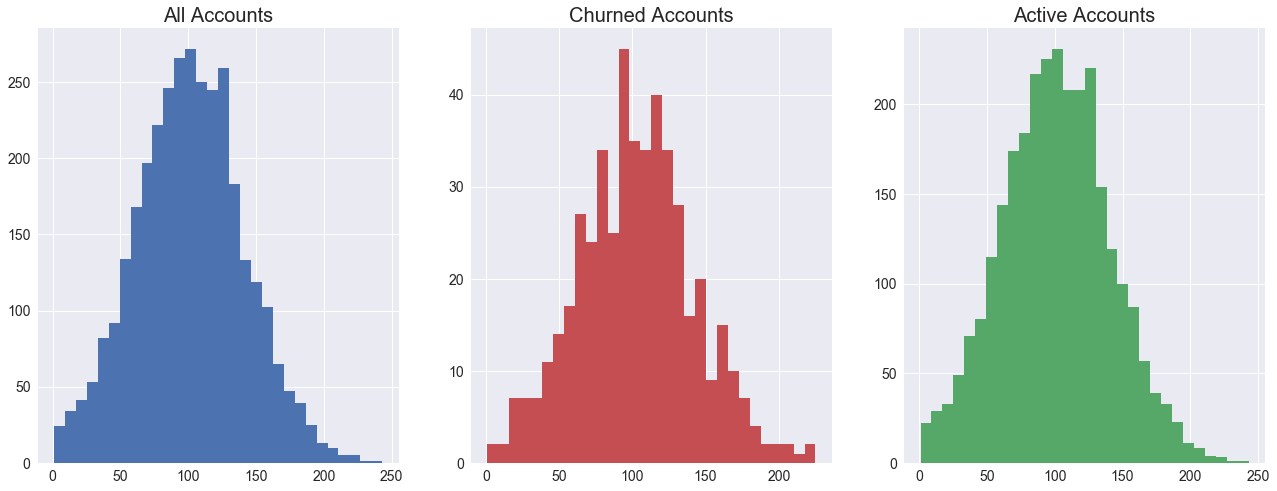

In [16]:
# check distribution of account lengths

px1 = df['Account Length']
px2 = df[df['Churn']==1]['Account Length']
px3 = df[df['Churn']==0]['Account Length']

plt.figure(figsize=[22,8])
plt.subplot(1,3,1)
plt.hist(px1, bins=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('All Accounts', fontsize=20)
plt.subplot(1,3,2)
plt.hist(px2, bins=30, color='C2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Churned Accounts', fontsize=20)
plt.subplot(1,3,3)
plt.hist(px3, bins=30, color='C1')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Active Accounts', fontsize=20)
plt.show()

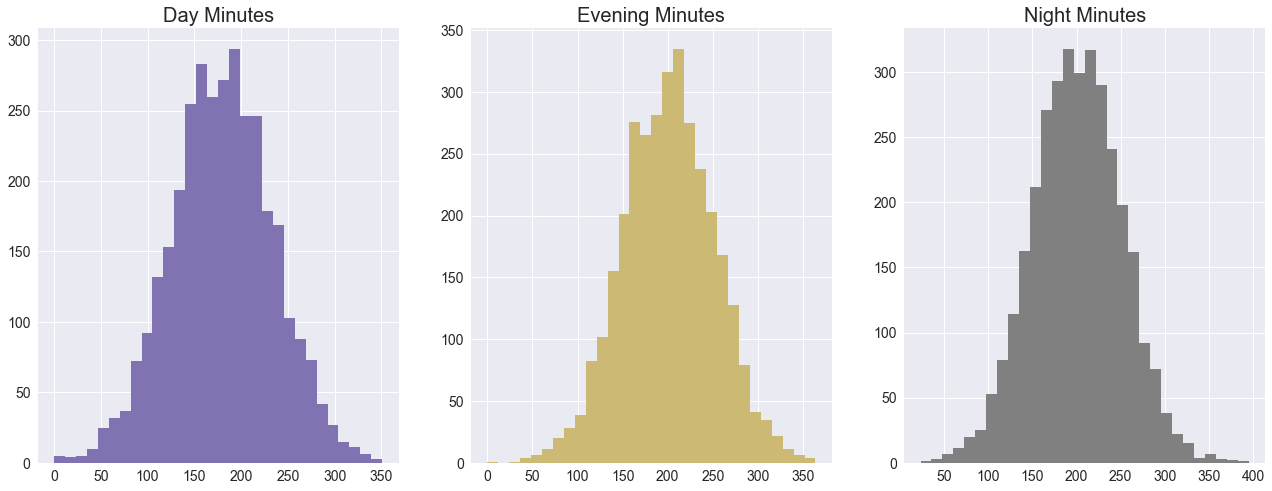

In [17]:
# check distribution of account lengths

px1 = df['Day Mins']
px2 = df['Eve Mins']
px3 = df['Night Mins']

plt.figure(figsize=[22,8])
plt.subplot(1,3,1)
plt.hist(px1, bins=30, color='C3')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Day Minutes', fontsize=20)
plt.subplot(1,3,2)
plt.hist(px2, bins=30, color='C4')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Evening Minutes', fontsize=20)
plt.subplot(1,3,3)
plt.hist(px3, bins=30, color='grey')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Night Minutes', fontsize=20)
plt.show()

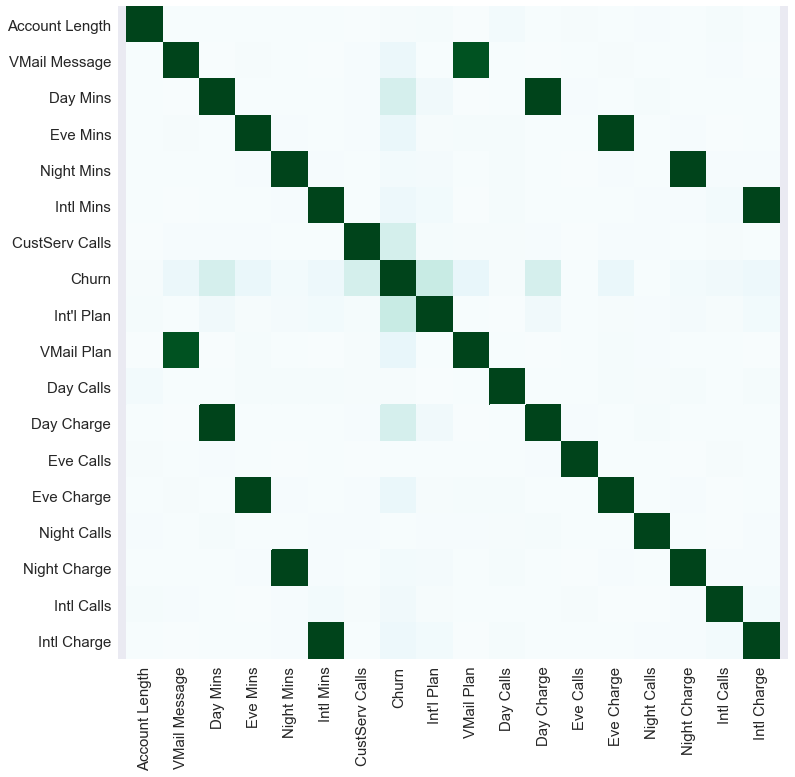

In [21]:
#evaluate correlations

plt.figure(figsize=[12,12])
sns.heatmap(np.abs(df.corr()), cmap='BuGn', cbar=False)
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

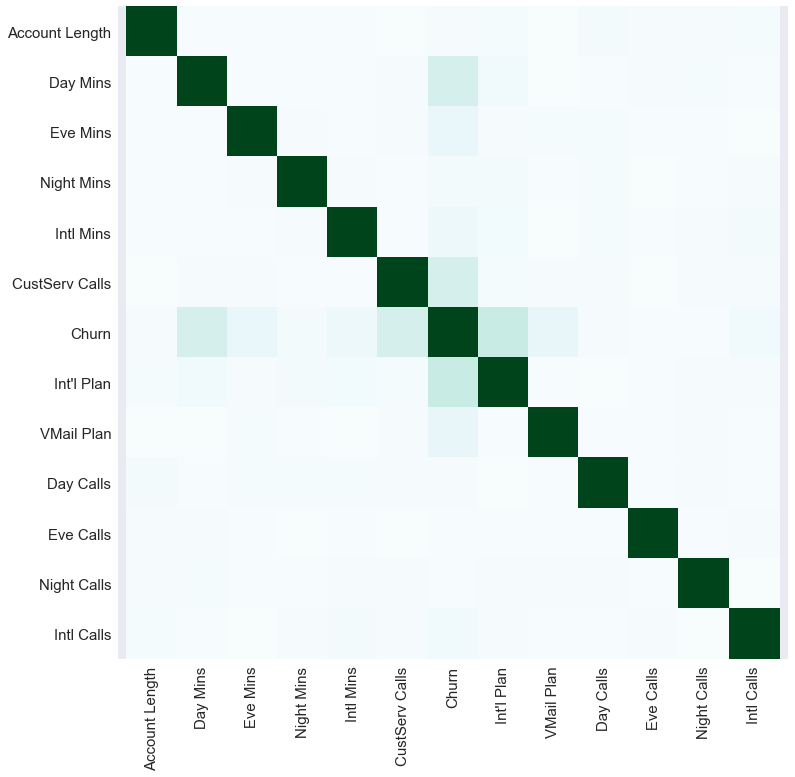

In [22]:
# drop correlated fields and re-evaluate correlations

tdf = df.drop(['VMail Message', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

plt.figure(figsize=[12,12])
sns.heatmap(np.abs(tdf.corr()), cmap='BuGn', cbar=False)
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Task 4:<br>Select and build model

## Skills:<br>Machine learning knowledge and skills

## To Do:<ul><li>What kind of a problem is this? See this <a href='https://sec.ch9.ms/ch9/ae0a/153986cb-3d94-47cc-b863-fe623b39ae0a/DataScienceForBeginners5QuestionsDataScienceCanAn_high.mp4'>video</a><li>Is the available data suitable for the model or is further transformation needed? (one-hot-encoding)<li>Can the results of the model be easily explained if necessary?<li>Do we need to perform feature/field selection?<li>When possible,try different (suitable) models and select the best one<li>Choose the most suitable algorithm...not just the coolest or newest one<li>ALWAYS test and evaluate the performance of your model<li>Select suitable evaluation metrics<li>Does the model generalize well to new/unseen data? ***<li>etc.

In [23]:
drop_Target = ['Churn']
drop_Useless = ['Phone', 'State', 'Area Code']
drop_Collinearity = ['VMail Message', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']

toDrop = drop_Target + drop_Useless + drop_Collinearity

X = df.drop(toDrop, axis=1)
shapeBefore = X.shape
X = pd.get_dummies(X)
shapeAfter = X.shape

y = df['Churn']

theCols = X.columns

print('Shape Before Encoding:', shapeBefore)
print('Shape After Encoding:', shapeAfter)

X_train, X_test, y_train, y_test = train_test_split(X,y)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

Shape Before Encoding: (3333, 12)
Shape After Encoding: (3333, 12)


In [24]:
#function to evaluate the "False Negative Rate" metric

def getFalseNegRate(y,yp):
    fn = Counter(zip(y,yp))[(1,0)]/len(list(y))
    return fn

In [25]:
false_neg_rate = make_scorer(getFalseNegRate, greater_is_better=False, needs_proba=False, needs_threshold=False)

In [26]:
numJobs = psutil.cpu_count(logical=False)

In [33]:
## RANDOM FOREST & EXTRATREES

theScrs = ['accuracy', 'roc_auc', 'neg_log_loss', 'brier_score_loss', 'precision', 'recall', 'f1']
scr = false_neg_rate

baseModel = RandomForestClassifier(class_weight='balanced')

estimatorList = range(25,301,25)
depthList = range(2,17,2)

hyperParams = {'n_estimators':estimatorList, 'max_depth':depthList}

clf = GridSearchCV(estimator=baseModel, param_grid=hyperParams, cv=3, scoring=scr, n_jobs=numJobs, verbose=1)

best_model = clf.fit(X_train, y_train)

# =========================================================================================

print('FNR Scoring:\nBest parameters for RF\n\t{}\n'.format(best_model.best_params_))

# =========================================================================================

yp_train = best_model.predict(X_train)
yp_test = best_model.predict(X_test)

# =========================================================================================

cvTrain = cross_val_score(best_model.best_estimator_, X_train, y_train, scoring=false_neg_rate, cv=3).mean()
accTrain = round(100*accuracy_score(y_train, yp_train),1)
print('\nTrain Score: {}'.format(cvTrain))
print('Training Accuracy: {}%'.format(accTrain))
print(confusion_matrix(y_true=y_train, y_pred=yp_train))

cvTest = cross_val_score(best_model.best_estimator_, X_test, y_test, scoring=false_neg_rate, cv=3).mean()
accTest = round(100*accuracy_score(y_test, yp_test),1)
print('\nTest Score: {}'.format(cvTest))
print('Test Accuracy: {}%'.format(accTest))
print(confusion_matrix(y_true=y_test, y_pred=yp_test))

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed:  1.3min finished


FNR Scoring:
Best parameters for RF
	{'max_depth': 4, 'n_estimators': 200}


Train Score: -0.02761104441776711
Training Accuracy: 90.8%
[[1955  175]
 [  56  313]]

Test Score: -0.0539568345323741
Test Accuracy: 89.4%
[[650  70]
 [ 18  96]]


In [34]:
# # ADABOOST

# theScrs = ['accuracy', 'roc_auc', 'neg_log_loss', 'brier_score_loss', 'precision', 'recall', 'f1']
# scr = false_neg_rate

# hyperparameters = {'n_estimators': (1,501),
#                    'learning_rate': (1e-4, 1, 'log-uniform'),
#                   }

# clf = BayesSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4)), hyperparameters, n_iter=48, cv=3, scoring=scr, n_jobs=numJobs, verbose=0, n_points=3)
# best_model = clf.fit(X_train, y_train)

# # =========================================================================================

# # print(scr.upper()+' Scoring:\nBest parameters for RF\n\t{}\n'.format(best_model.best_params_))
# print('FNR Scoring:\nBest parameters for AdaBoost\n\t{}\n'.format(best_model.best_params_))

# # =========================================================================================

# yp_train = best_model.predict(X_train)
# yp_test = best_model.predict(X_test)

# # =========================================================================================

# cvTrain = cross_val_score(best_model.best_estimator_, X_train, y_train, scoring=false_neg_rate, cv=3).mean()
# accTrain = round(100*accuracy_score(y_train, yp_train),1)
# print('\nTrain Score: {}'.format(cvTrain))
# print('Training Accuracy: {}%'.format(accTrain))
# print(confusion_matrix(y_true=y_train, y_pred=yp_train))

# cvTest = cross_val_score(best_model.best_estimator_, X_test, y_test, scoring=false_neg_rate, cv=3).mean()
# accTest = round(100*accuracy_score(y_test, yp_test),1)
# print('\nTest Score: {}'.format(cvTest))
# print('Test Accuracy: {}%'.format(accTest))
# print(confusion_matrix(y_true=y_test, y_pred=yp_test))

In [35]:
# # XGBOOST

# scalePosWeight=labelSkew[0]/labelSkew[1]

# theScrs = ['accuracy', 'roc_auc', 'neg_log_loss', 'brier_score_loss', 'precision', 'recall', 'f1']
# scr = false_neg_rate

# hyperparameters = {'n_estimators': (200,501),
#                    'max_depth': (4,16),
#                    'learning_rate': (1e-4, 1, 'log-uniform'),
#                    'reg_lambda': (1e-4, 1, 'log-uniform'),
#                    'reg_alpha': (1e-4, 1, 'log-uniform'),
#                   }

# clf = BayesSearchCV(XGBClassifier(scale_pos_weight=scalePosWeight), hyperparameters, n_iter=48, cv=3, scoring=scr, n_jobs=numJobs, verbose=0, n_points=3)
# best_model = clf.fit(X_train, y_train)

# # =========================================================================================

# # print(scr.upper()+' Scoring:\nBest parameters for RF\n\t{}\n'.format(best_model.best_params_))
# print('FNR Scoring:\nBest parameters for XGBoost\n\t{}\n'.format(best_model.best_params_))

# # =========================================================================================

# yp_train = best_model.predict(X_train)
# yp_test = best_model.predict(X_test)

# # =========================================================================================

# cvTrain = cross_val_score(best_model.best_estimator_, X_train, y_train, scoring=false_neg_rate, cv=3).mean()
# accTrain = round(100*accuracy_score(y_train, yp_train),1)
# print('\nTrain Score: {}'.format(cvTrain))
# print('Training Accuracy: {}%'.format(accTrain))
# print(confusion_matrix(y_true=y_train, y_pred=yp_train))

# cvTest = cross_val_score(best_model.best_estimator_, X_test, y_test, scoring=false_neg_rate, cv=3).mean()
# accTest = round(100*accuracy_score(y_test, yp_test),1)
# print('\nTest Score: {}'.format(cvTest))
# print('Test Accuracy: {}%'.format(accTest))
# print(confusion_matrix(y_true=y_test, y_pred=yp_test))

## Task 5:<br>Communicate the results (or deploy the model into production)

## Skills:<br>Communication skills

## To Do:<ul><li>Target audience is most likely the business or the leaders?<li>Avoid the temptation to use DS jargon; communicate to the business in their language<li>Be sure to address the business problem you set out to solve<li>Working with the business SMEs, find out which of the findings from your model are actionable<li>etc.

In [36]:
theImps = sorted(zip(theCols, best_model.best_estimator_.feature_importances_), key=lambda x:x[1], reverse=True)

tuplesFeaturePolarity = []

for i in theImps:
    thisCorr = np.corrcoef(X[i[0]], y)[1,0]
    thisCorr = round(thisCorr,3)
#     print((i[0], thisCorr))
    if thisCorr>=0:
        thisPolarity = 'DRIVES UP'
    else:
        thisPolarity = 'DRIVES DOWN'
    tuplesFeaturePolarity.append( (i[0], round(100*i[1],2), thisPolarity) )

impDF = pd.DataFrame(tuplesFeaturePolarity, columns=['Feature', 'Importance (%)', 'Direction'])
impDF

,Feature,Importance (%),Direction
0,Day Mins,32.18,DRIVES UP
1,CustServ Calls,22.46,DRIVES UP
2,Int'l Plan,16.71,DRIVES UP
3,Eve Mins,6.81,DRIVES UP
4,VMail Plan,5.51,DRIVES DOWN
5,Intl Mins,4.20,DRIVES UP
6,Intl Calls,3.98,DRIVES DOWN
7,Night Mins,3.13,DRIVES UP
8,Night Calls,1.30,DRIVES UP
9,Eve Calls,1.25,DRIVES UP


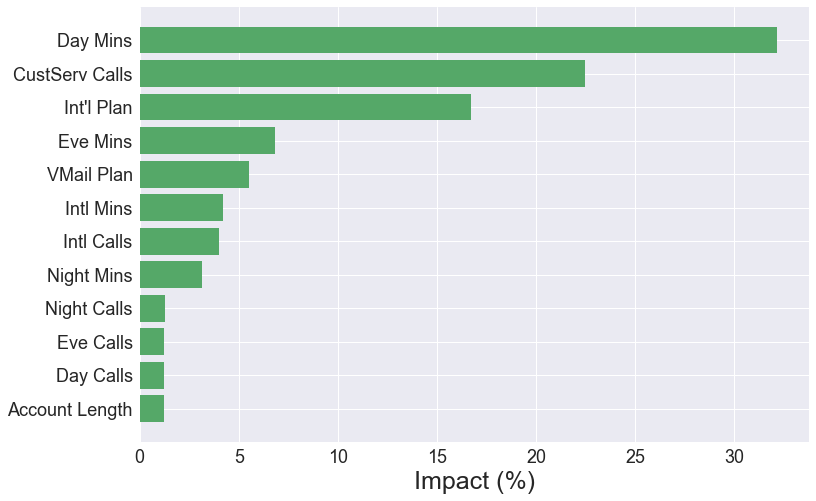

In [37]:
px = impDF['Feature']
py = impDF['Importance (%)']

plt.figure(figsize=[12,8])
plt.barh(px, py, color='C1')
plt.gca().invert_yaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Impact (%)', fontsize=25)
plt.show()

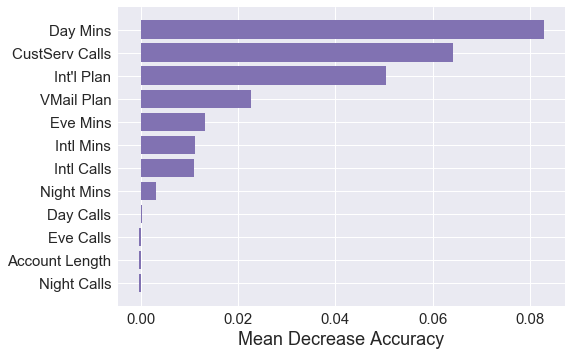

In [38]:
# verify feature ranking by means of "Mean Decrease in Accuracy"

xx = X.values

scores = defaultdict(list)

reg = best_model.best_estimator_

numSplits = 500

shuffSplit = ShuffleSplit(n_splits=numSplits, test_size=0.3)
cntr = 0

for train_idx, test_idx in shuffSplit.split(xx):
    cntr += 1
    X_train, X_test = xx[train_idx], xx[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    rf = reg.fit(X_train, Y_train)
    acc = accuracy_score(Y_test, rf.predict(X_test))
    for i in range(xx.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = accuracy_score(Y_test, rf.predict(X_t))
        scores[theCols[i]].append((acc-shuff_acc)/acc)

mda_features = list(scores.keys())
mda_importance = [(np.mean(score)) for score in scores.values()]

p = sorted(zip(mda_features, mda_importance), key=lambda x:x[1])
px = [i[0] for i in p]
py = [i[1] for i in p]

plt.barh(px, py, color='C3')
plt.xlabel('Mean Decrease Accuracy', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# CONCLUSION
## PRACTICE is the surest way to improve these skills and become more confident<li>Get your hands dirty<li>Don't be afraid to get the wrong answer (but avoid fudging at all cost)<li>Two heads are better than one (teamwork and collaboration)<li>Don't reinvent the wheel. Use well tested libraries when possible


# FINAL MESSAGE:<br>Data science is a toolbox...<br>Once a problem has been CLEARLY DEFINED, reach into the toolbox to select the tools you need to solve it.